In [7]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from collections import defaultdict


sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

from modules.data_handling import load_data, load_and_normalize_data
from modules.model_training import train_and_predict_single_gp
from modules.model_training import GPModel, to_torch
from modules.fusion_methods import product_fusion
from modules.fusion_methods import compute_neg_log_like
from modules.model_training import train_expert, predict_with_expert, train_and_predict_batched_gp
from modules.model_training import train_and_predict_batched_svgp


import torch
from tqdm import tqdm

import gpytorch
from gpytorch.means import ZeroMean
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.metrics import mean_standardized_log_loss


import numpyro
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from optax import adam, chain, clip

from numpyro import distributions as dist
import jax
import jax.numpy as jnp
import jax.random as random

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
numpyro.enable_x64()

from uci_datasets import Dataset

In [8]:
def run_single_gp(dataset_name, lr = 0.1, training_iter=100):
    nlpd = []
    rmse = []
    for i in tqdm(range(10)):
        try:
            X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,i)

            # With load_and_normalize_data fun the data is normalized using the training data only
            # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,i,
            #                                                         normalize_y=True,
            #                                                         normalize_x_method="z-score")

            test_preds, _ = train_and_predict_single_gp(X_train,y_train,X_test,X_test,
                                    mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
                                    lr=lr,
                                    training_iter=training_iter,
                                    initialiaze_hyper=False, # if false, kappa and lambdaa don't matter!
                                    )
            nlpd_now = compute_neg_log_like(test_preds.mean,np.sqrt(test_preds.variance),y_test)
            rmse_now = np.sqrt(np.mean((test_preds.mean.numpy().squeeze() - y_test)**2))

            nlpd.append(nlpd_now.squeeze())
            rmse.append(rmse_now)
        except:
            print("There was an error during hyperparameter learning.")

    nlpd = np.array(nlpd)
    rmse = np.array(rmse)

    return nlpd, rmse


def run_gam_gp(dataset_name, lr = 0.1, training_iter = 100):

    nlpd = []
    rmse = []
    for i in tqdm(range(10)):
        try:
            X_train, y_train, X_test, y_test, y_std = load_data(dataset_name,i)

            # With load_and_normalize_data fun the data is normalized using the training data only
            # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,i,
            #                                                         normalize_y=True,
            #                                                         normalize_x_method="z-score")
              

            kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), 
                                             num_dims=X_train.shape[1])

            test_preds, _ = train_and_predict_single_gp(X_train,y_train,X_test,X_test,
                                    kappa=2,lambdaa=2,
                                    mean=ZeroMean(),  # we don't want to use the mean of y_train as prior mean
                                    kernel=kernel,
                                    lr=0.1,
                                    training_iter=200,
                                    initialiaze_hyper=False, # if False, kappa and lambdaa are not used for initializing the hyperparameters; we just use the default values.
                                    )
            nlpd_now = compute_neg_log_like(test_preds.mean,np.sqrt(test_preds.variance),y_test)
            rmse_now = np.sqrt(np.mean((test_preds.mean.detach().numpy().squeeze() - y_test)**2))

            nlpd.append(nlpd_now.squeeze())
            rmse.append(rmse_now)
        except:
            print("There was an error during hyperparameter learning.")

    nlpd = np.array(nlpd)
    rmse = np.array(rmse)

    return nlpd, rmse






def run_stacked_proj_gp_batched(dataset_name, num_projections, project_dim,
                        proj = "random",lr = 0.1, training_iter = 100,
                        kernel = None,
                        ):
    results = defaultdict(lambda: {"nlpd": [], "rmse": []})

    configs = [
        {'weighting': 'uniform', 'method': 'gPoE', 'normalize': True},
        {'weighting': 'entropy', 'method': 'gPoE', 'normalize': True},
        {'weighting': 'entropy', 'method': 'gPoE', 'normalize': False},
        {'weighting': 'entropy', 'method': 'rBCM', 'normalize': False}
    ]

    for split in tqdm(range(10)):
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name, split)

        # With load_and_normalize_data fun the data is normalized using the training data only
        # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,split,
        #                                                             normalize_y=True,
        #                                                             normalize_x_method="z-score")

        mean_experts = []
        std_experts = []
        std_experts_prior = []

        X_train_batched = np.zeros((num_projections,X_train.shape[0],project_dim))
        X_test_batched = np.zeros((num_projections,X_test.shape[0],project_dim))
        y_train_batched = np.zeros((num_projections,y_train.shape[0]))
        for d in range(num_projections):  
            if proj == "random":
                np.random.seed(d)
                P_proj = np.random.randn(X_train.shape[1], project_dim) / np.sqrt(project_dim)
            elif proj == "axis":
                P_proj = np.array([1.0 if i == d else 0.0 for i in range(X_train.shape[1])])
                P_proj = P_proj.reshape(-1, 1)

            X_train_batched[d,:,:] = np.matmul(X_train,P_proj)
            y_train_batched[d,:] = y_train

            X_test_batched[d,:,:] = np.matmul(X_test,P_proj)


        # train all the experts in batch mode
        preds, preds_prior = train_and_predict_batched_gp(X_train_batched, 
                                                          y_train_batched, 
                                                          X_test_batched,
                                                          training_iter=training_iter, lr=lr,
                                                          kernel = kernel,
                                                          )


        mean_experts = preds.mean.numpy().T
        std_experts = np.sqrt(preds.variance.numpy().T)
        std_experts_prior = np.sqrt(preds_prior.variance.numpy().T)

        for config in configs:
            mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                      std_experts,
                                                      std_experts_prior,
                                                      weighting=config["weighting"],
                                                      normalize=config["normalize"],
                                                      method=config["method"])

            nlpd_now = compute_neg_log_like(mean_fused, std_fused, y_test).squeeze()
            rmse_now = np.sqrt(np.mean((mean_fused.squeeze() - y_test.squeeze())**2))

            # Store the results
            config_key = f'{config["method"]}_{config["weighting"]}_normalize_{config["normalize"]}'
            results[config_key]["nlpd"].append(nlpd_now)
            results[config_key]["rmse"].append(rmse_now)

    # Calculate the mean performance measures across all splits for each configuration
    mean_results = {key: {"mean_nlpd": np.mean(value["nlpd"]), 
                          "mean_rmse": np.mean(value["rmse"]),
                          "std_err_nlpd": np.std(value["nlpd"])/np.sqrt(10), 
                          "std_err_rmse": np.std(value["rmse"])/np.sqrt(10),
                          }
                    for key, value in results.items()}

    return mean_results


In [9]:
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = 'autompg'#dataset_names[1]
data = Dataset(dataset_name)
N,DIM = data.x.shape

autompg dataset, N=392, d=7


# Baselines

In [32]:
nlpd1, rmse1  = run_single_gp(dataset_name)
nlpd2, rmse2  = run_gam_gp(dataset_name)

# single GP results
print(f"{'single gp':<15} nlpd: {nlpd1.mean():.2f} ± {nlpd1.std()/np.sqrt(10):.2f}, rmse: {rmse1.mean():.2f} ± {rmse1.std()/np.sqrt(10):.2f}")

# gam GP results
print(f"{'gam gp':<15} nlpd: {nlpd2.mean():.2f} ± {nlpd2.std()/np.sqrt(10):.2f}, rmse: {rmse2.mean():.2f} ± {rmse2.std()/np.sqrt(10):.2f}")


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

single gp       nlpd: 0.33 ± 0.05, rmse: 0.34 ± 0.01
gam gp          nlpd: 0.37 ± 0.03, rmse: 0.35 ± 0.01


# Batched GPs

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


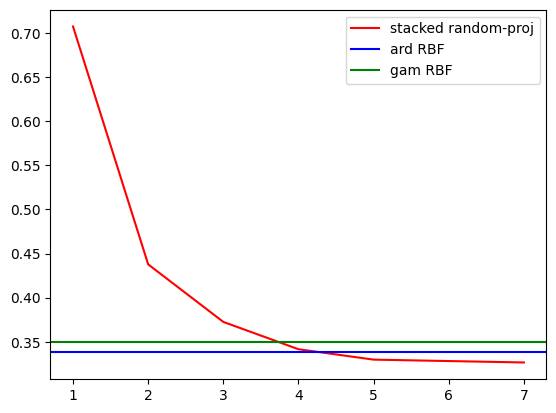

In [40]:
project_dim_vals = np.linspace(1,DIM,6)
project_dim_vals = project_dim_vals.astype(int)
num_projections = 20


nlpd = []
rmse = []
for _,project_dim in enumerate(project_dim_vals):

    kernel = gpytorch.kernels.SpectralDeltaKernel(num_dims = project_dim, num_deltas=32, 
                                              batch_shape=torch.Size([num_projections]))
    kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_projections]),
                                       ard_num_dims=project_dim),
            batch_shape=torch.Size([num_projections])
        )
    kernel = gpytorch.kernels.InducingPointKernel(kernel,
                                                inducing_points=torch.randn((num_projections, project_dim, 500)), 
                                                likelihood=GaussianLikelihood())
    
    kernel = None
    # print(project_dim)
    results = run_stacked_proj_gp_batched(dataset_name, num_projections, 
                                          project_dim = project_dim, kernel = kernel)

    nlpd.append(results["gPoE_uniform_normalize_True"]["mean_nlpd"])
    rmse.append(results["gPoE_uniform_normalize_True"]["mean_rmse"])

nlpd_stack = np.array(nlpd)
rmse_stack = np.array(rmse)

plt.plot(project_dim_vals,rmse_stack,label = "stacked random-proj", color = "red")
plt.axhline(rmse1.mean(), label = "ard RBF", color = "blue")
plt.axhline(rmse2.mean(), label = "gam RBF", color = "green")
plt.legend()
    

## testing values of project_dim and num_projections

In [15]:
project_dim_vals = np.linspace(1,DIM,6)
project_dim_vals = project_dim_vals.astype(int)

rmse_stacks = []
nlpd_stacks = []

for num_projections in [2, 5, 10, 20]:
    nlpd = []
    rmse = []
    for _,project_dim in enumerate(project_dim_vals):
        # print(project_dim)
        results = run_stacked_proj_gp_batched(dataset_name, num_projections, project_dim = project_dim)

        nlpd.append(results["gPoE_uniform_normalize_True"]["mean_nlpd"])
        rmse.append(results["gPoE_uniform_normalize_True"]["mean_rmse"])

    nlpd_stack = np.array(nlpd)
    rmse_stack = np.array(rmse)

    rmse_stacks.append(rmse_stack)
    nlpd_stacks.append(nlpd_stack)

100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


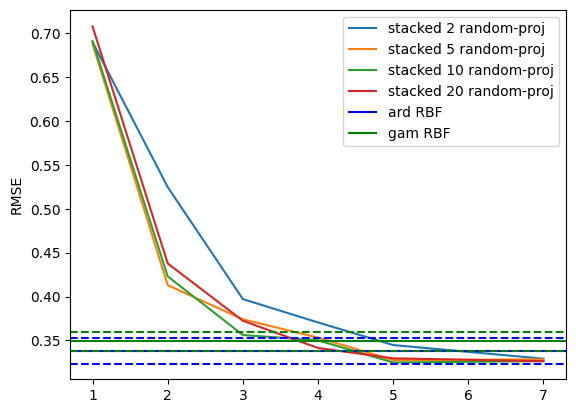

In [18]:
dims = [2, 5, 10, 20]
for i, rmse_stack in enumerate(rmse_stacks):
    plt.plot(project_dim_vals,rmse_stack,label = f"stacked {dims[i]} random-proj")
plt.axhline(rmse1.mean(), label = "ard RBF", color = "blue")
plt.axhline(rmse1.mean() - rmse1.std() / np.sqrt(10), color = "blue", linestyle='dashed')

plt.axhline(rmse1.mean() + rmse1.std() / np.sqrt(10), color = "blue", linestyle='dashed')
plt.axhline(rmse2.mean(), label = "gam RBF", color = "green")
plt.axhline(rmse2.mean() - rmse2.std() / np.sqrt(10), color = "green", linestyle='dashed')

plt.axhline(rmse2.mean() + rmse2.std() / np.sqrt(10),  color = "green", linestyle='dashed')
plt.ylabel("RMSE")
plt.legend()
        

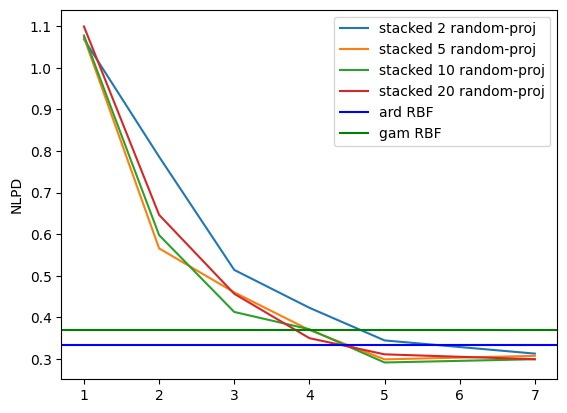

In [19]:
dims = [2, 5, 10, 20]
for i, nlpd_stack in enumerate(nlpd_stacks):
    plt.plot(project_dim_vals,nlpd_stack,label = f"stacked {dims[i]} random-proj")
plt.axhline(nlpd1.mean(), label = "ard RBF", color = "blue")
plt.axhline(nlpd2.mean(), label = "gam RBF", color = "green")
plt.ylabel("NLPD")
plt.legend()

# Batched SVGPs

In [41]:
def run_stacked_proj_svgp_batched(dataset_name, num_projections, project_dim,
                        proj = "random",lr = 0.1, num_epochs = 10,
                        batch_size = 128,
                        ):
    results = defaultdict(lambda: {"nlpd": [], "rmse": []})

    configs = [
        {'weighting': 'uniform', 'method': 'gPoE', 'normalize': True},
        # {'weighting': 'entropy', 'method': 'gPoE', 'normalize': True},
        # {'weighting': 'entropy', 'method': 'gPoE', 'normalize': False},
        # {'weighting': 'entropy', 'method': 'rBCM', 'normalize': False}
    ]

    for split in tqdm(range(10)):
        X_train, y_train, X_test, y_test, y_std = load_data(dataset_name, split)

        # With load_and_normalize_data fun the data is normalized using the training data only
        # X_train, y_train, X_test, y_test = load_and_normalize_data(dataset_name,split,
        #                                                             normalize_y=True,
        #                                                             normalize_x_method="z-score")

        mean_experts = []
        std_experts = []
        std_experts_prior = []

        X_train_batched = np.zeros((num_projections,X_train.shape[0],project_dim))
        X_test_batched = np.zeros((num_projections,X_test.shape[0],project_dim))
        y_train_batched = np.zeros((num_projections,y_train.shape[0]))
        for d in range(num_projections):  
            if proj == "random":
                np.random.seed(d)
                P_proj = np.random.randn(X_train.shape[1], project_dim) / np.sqrt(project_dim)
            elif proj == "axis":
                P_proj = np.array([1.0 if i == d else 0.0 for i in range(X_train.shape[1])])
                P_proj = P_proj.reshape(-1, 1)

            X_train_batched[d,:,:] = np.matmul(X_train,P_proj)
            y_train_batched[d,:] = y_train.squeeze()

            X_test_batched[d,:,:] = np.matmul(X_test,P_proj)


        # train all the experts in batch mode
        means, stds = train_and_predict_batched_svgp(X_train_batched, 
                                                          y_train_batched, 
                                                          X_test_batched,
                                                          num_epochs=num_epochs, 
                                                          lr=lr,
                                                          batch_size=batch_size,
                                                          )


        mean_experts = means.T
        std_experts = stds.T
        # std_experts_prior = np.sqrt(preds_prior.variance.numpy().T)

        for config in configs:
            mean_fused, std_fused, _ = product_fusion(mean_experts,
                                                      std_experts,
                                                    #   std_experts_prior,
                                                      weighting=config["weighting"],
                                                      normalize=config["normalize"],
                                                      method=config["method"])

            nlpd_now = compute_neg_log_like(mean_fused, std_fused, y_test).squeeze()
            rmse_now = np.sqrt(np.mean((mean_fused.squeeze() - y_test.squeeze())**2))

            # Store the results
            config_key = f'{config["method"]}_{config["weighting"]}_normalize_{config["normalize"]}'
            results[config_key]["nlpd"].append(nlpd_now)
            results[config_key]["rmse"].append(rmse_now)

    # Calculate the mean performance measures across all splits for each configuration
    mean_results = {key: {"mean_nlpd": np.mean(value["nlpd"]), 
                          "mean_rmse": np.mean(value["rmse"]),
                          "std_err_nlpd": np.std(value["nlpd"])/np.sqrt(10), 
                          "std_err_rmse": np.std(value["rmse"])/np.sqrt(10),
                          }
                    for key, value in results.items()}

    return mean_results

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


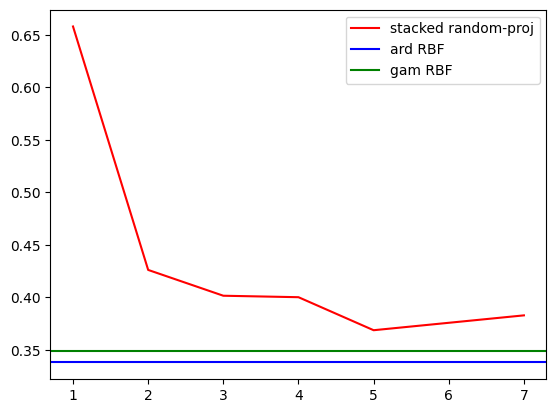

In [46]:
num_projections = 20
project_dim_vals = np.linspace(1,DIM,6)
project_dim_vals = project_dim_vals.astype(int)

nlpd = []
rmse = []
for _,project_dim in enumerate(project_dim_vals):


    results = run_stacked_proj_svgp_batched(dataset_name, num_projections, 
                                          project_dim = project_dim,
                                          num_epochs=10, 
                                          lr=0.1,
                                          batch_size=50,
                                          )

    nlpd.append(results["gPoE_uniform_normalize_True"]["mean_nlpd"])
    rmse.append(results["gPoE_uniform_normalize_True"]["mean_rmse"])

nlpd_stack = np.array(nlpd)
rmse_stack = np.array(rmse)

plt.plot(project_dim_vals,rmse_stack,label = "stacked random-proj", color = "red")
plt.axhline(rmse1.mean(), label = "ard RBF", color = "blue")
plt.axhline(rmse2.mean(), label = "gam RBF", color = "green")
plt.legend();


# En sucio...

In [12]:
from gpytorch.models import ApproximateGP
import gpytorch

class BatchVariationalGPModel(ApproximateGP):
    def __init__(self, train_x, kernel=None, mean=None):
        inducing_points = train_x[:,:100,:]
        # inducing_points = to_torch(np.random.rand((100,train_x.shape[2])))
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.shape[1],
                                                                   batch_shape=torch.Size([train_x.shape[0]]))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(BatchVariationalGPModel, self).__init__(variational_strategy)
        self.mean_module = mean or ZeroMean(batch_shape=torch.Size([train_x.shape[0]]))
        self.covar_module = kernel or ScaleKernel(RBFKernel(ard_num_dims=train_x.shape[2],
                                                            batch_shape=torch.Size([train_x.shape[0]])),
                                                  batch_shape=torch.Size([train_x.shape[0]]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [13]:
X_train = data.x

In [14]:
X_train = to_torch(X_train).unsqueeze(0)

X_train = torch.vstack([X_train, X_train.clone()])

y_train = to_torch(data.y).unsqueeze(0)
y_train = torch.vstack([y_train, y_train.clone()])

In [15]:
X_train.shape

torch.Size([2, 392, 7])

In [16]:

likelihood = GaussianLikelihood()
model = BatchVariationalGPModel(X_train)

In [17]:
model(X_train)

MultivariateNormal(loc: torch.Size([2, 392]))

In [18]:
model.forward(X_train)

MultivariateNormal(loc: torch.Size([2, 392]))

In [19]:
X_train.shape, y_train.shape

(torch.Size([2, 392, 7]), torch.Size([2, 392, 1]))

In [20]:

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train.shape[1])

mll(model(X_train),y_train.squeeze()).sum()

tensor(-90.1209, grad_fn=<SumBackward0>)

In [21]:
X_train = to_torch(data.x)
y_train = to_torch(data.y)


X_train = data.x
y_train = data.y
X_train = to_torch(X_train).unsqueeze(0)

X_train = torch.vstack([X_train, X_train.clone()])

y_train = to_torch(data.y).unsqueeze(0)
y_train = torch.vstack([y_train, y_train.clone()]).squeeze()

In [22]:
X_train.shape, y_train.shape, y_train.transpose(0, 1).shape

(torch.Size([2, 392, 7]), torch.Size([2, 392]), torch.Size([392, 2]))

In [23]:
from torch.utils.data import TensorDataset, DataLoader


train_dataset = TensorDataset(X_train.transpose(0, 1), y_train.transpose(0, 1))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [24]:
from gpytorch.mlls import VariationalELBO

optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
mll = VariationalELBO(likelihood, model, num_data=X_train.shape[1])

model.train()
likelihood.train()
for num_epochs in range(5):
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.transpose(0, 1)
        y_batch = y_batch.transpose(0, 1)
        # print(X_batch.shape)
        # print(y_batch.shape)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = -mll(output, y_batch).sum()
        loss.backward()
        optimizer.step()
        print(loss)

tensor(104.3722, grad_fn=<NegBackward0>)
tensor(75.8736, grad_fn=<NegBackward0>)
tensor(70.3472, grad_fn=<NegBackward0>)
tensor(124.6660, grad_fn=<NegBackward0>)
tensor(67.9660, grad_fn=<NegBackward0>)
tensor(67.6139, grad_fn=<NegBackward0>)
tensor(60.0483, grad_fn=<NegBackward0>)
tensor(38.9339, grad_fn=<NegBackward0>)
tensor(60.7029, grad_fn=<NegBackward0>)
tensor(53.0305, grad_fn=<NegBackward0>)
tensor(44.2216, grad_fn=<NegBackward0>)
tensor(38.1548, grad_fn=<NegBackward0>)
tensor(48.3536, grad_fn=<NegBackward0>)
tensor(42.0034, grad_fn=<NegBackward0>)
tensor(42.3614, grad_fn=<NegBackward0>)
tensor(30.2974, grad_fn=<NegBackward0>)
tensor(39.0010, grad_fn=<NegBackward0>)
tensor(37.0909, grad_fn=<NegBackward0>)
tensor(37.7231, grad_fn=<NegBackward0>)
tensor(48.4509, grad_fn=<NegBackward0>)


In [25]:
model.named_variational_parameters

<bound method Module.named_variational_parameters of BatchVariationalGPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)>

In [26]:
X_test = X_train + 1
X_test.shape

torch.Size([2, 392, 7])

In [27]:
model.eval()
likelihood.eval()

test_dataset = TensorDataset(X_test.transpose(0, 1))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

means = []
variances = []

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for X_batch in test_loader:
        X_batch = X_batch[0]  # Unpack the tuple
        X_batch = X_batch.transpose(0, 1)
        preds = likelihood(model(X_batch))
        means.append(preds.mean.cpu().numpy())
        variances.append(preds.variance.cpu().numpy())

mean = np.concatenate(means, axis=1)
var = np.concatenate(variances, axis=1)        

In [29]:
mean.shape, var.shape

((2, 392), (2, 392))